In [11]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

df = pd.read_excel("DATASET.xlsx")
df.head()
df['Sample'] = df['Sample'].fillna('').astype(str)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
labels = ['Hate Speech', 'Derogatory', 'Trolling', 'Profanity', 'Normal']

predictions = []
for sample in df['Sample']:
    inputs = tokenizer(sample, 
                       return_tensors = 'pt',
                       truncation = True,
                       max_length = 512, #needed
                       padding = True)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    probabilities = softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    predictions.append( (labels[predicted_class], probabilities[0][predicted_class].item()))

In [12]:
df['Predicted_Label'], df['Prediction_Confidence'] = zip(*predictions)
print(df.head())

                                              Sample Annotator_1 Annotator_2  \
0                                     Is he 5 or 6 ?      Normal    Trolling   
1                                      I peed!  Lmao      Normal    Trolling   
2        Hey aren't you that guy from lemony snicket      Normal      Normal   
3                Your runway name should be Methany.    Trolling    Trolling   
4  No Need to roast, if you are a SDL for Frito L...    Trolling      Normal   

  Annotator_3 Majority_label Predicted_Label  Prediction_Confidence  
0      Normal         Normal        Trolling               0.224506  
1      Normal         Normal        Trolling               0.239669  
2      Normal         Normal          Normal               0.231963  
3      Normal       Trolling        Trolling               0.251247  
4    Trolling       Trolling        Trolling               0.218274  


Accuracy: 0.3077


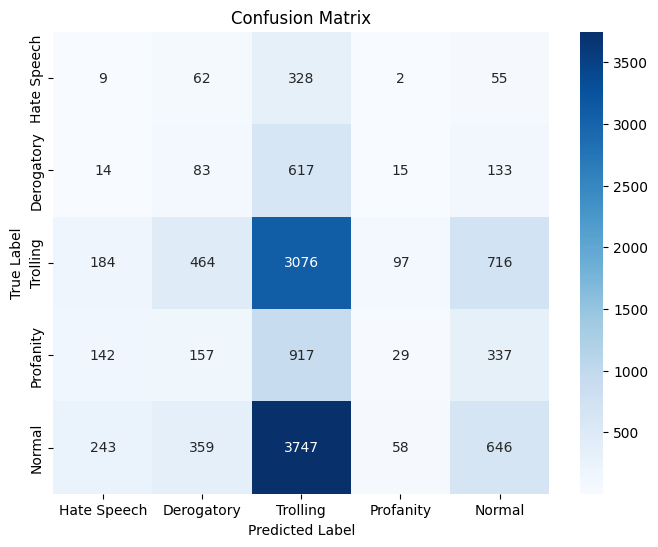

In [22]:
actual_labels = df['Majority_label'].tolist()
predicted_labels = df['Predicted_Label'].tolist()

accuracy = accuracy_score(actual_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')



cm = confusion_matrix(actual_labels, predicted_labels, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()